# **Initialization**

In [ ]:
import os
import random
import shutil
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch

if torch.cuda.is_available():
    print("GPU is enabled and available!")
    print("Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available. Please check runtime settings.")


GPU is enabled and available!
Device Name: Tesla P100-PCIE-16GB


# **DenseNet121**

## **Import Libraries and Set Random Seeds**

In [2]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from skimage import morphology, measure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Define Dataset Paths and Parameters**

In [3]:
# Dataset paths
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Preprocessing and Augmentation**

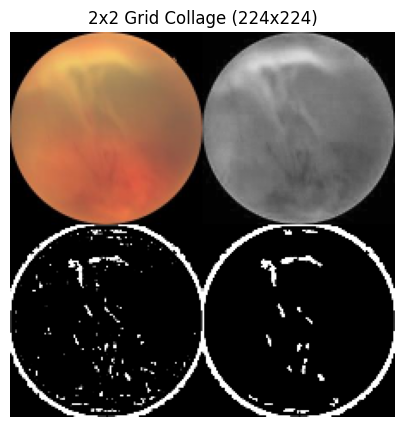

In [4]:
# Vessel Segmentation Function
def vessel_segmentation(image):
    # Step 1: Resize image
    resized_image = cv2.resize(image, (512, 512))

    # Step 2: Extract green channel and convert to uint8
    green_channel = resized_image[:, :, 1].astype(np.uint8)  # Ensure it's uint8

    # Step 3: Enhance using CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(green_channel)

    # Step 4: Apply adaptive thresholding and invert it
    adaptive_thresh_image = cv2.adaptiveThreshold(enhanced_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 25, 6)
    inverted_thresh_image = cv2.bitwise_not(adaptive_thresh_image)

    # Step 5: Apply median filtering to reduce noise
    median_filtered_image = cv2.medianBlur(inverted_thresh_image, 5)

    # Step 6: Apply morphological opening to remove small dots before dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened_image = cv2.morphologyEx(median_filtered_image, cv2.MORPH_OPEN, kernel)

    # Step 7: Apply morphological dilation with a smaller kernel size
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_image = cv2.dilate(opened_image, kernel)

    # Step 8: Remove small objects (increase min_size to remove smaller dots)
    labels = measure.label(dilated_image)
    cleaned = morphology.remove_small_objects(labels, min_size=100)
    final_image = (cleaned > 0).astype(np.uint8) * 255

    # Convert grayscale to 3-channel for visualization
    enhanced_image = cv2.merge([enhanced_image] * 3)
    inverted_thresh_image = cv2.merge([inverted_thresh_image] * 3)
    final_image = cv2.merge([final_image] * 3)

    return resized_image, enhanced_image, inverted_thresh_image, final_image

# Create 2x2 Grid Collage
def create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image):
    # Resize all images to half the size of the final collage (112x112)
    size = (112, 112)  # Each image will be 112x112
    resized_image = cv2.resize(resized_image, size)
    enhanced_image = cv2.resize(enhanced_image, size)
    inverted_thresh_image = cv2.resize(inverted_thresh_image, size)
    final_image = cv2.resize(final_image, size)

    # Create 2x2 grid
    top_row = np.hstack((resized_image, enhanced_image))  # Top row: Original + CLAHE
    bottom_row = np.hstack((inverted_thresh_image, final_image))  # Bottom row: Inverted + Final
    collage = np.vstack((top_row, bottom_row))  # Combine rows into 2x2 grid

    return collage

# Resize Collage to Target Size
def resize_collage(collage, target_size):

    return cv2.resize(collage, target_size)

# Get first image file in the training directory
first_class = os.listdir(TRAIN_DIR)[0]  # Get first class folder
first_class_path = os.path.join(TRAIN_DIR, first_class)
first_image_file = os.listdir(first_class_path)[2]  # Get first image file
first_image_path = os.path.join(first_class_path, first_image_file)

# Load the image
image = cv2.imread(first_image_path)

# Process the image and create the 2x2 collage
resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)

# Resize the collage to 224x224
collage = resize_collage(collage, (224, 224))

# Display the collage
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
plt.title("2x2 Grid Collage (224x224)")
plt.axis('off')
plt.show()

In [5]:
# Data Generators with Vessel Segmentation

# Custom Data Generator
def custom_data_generator(datagen, directory, target_size, batch_size, class_mode, shuffle=True):
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle  # Pass the shuffle argument
    )

    while True:
        batch_images, batch_labels = next(generator)

        collages = []
        for image in batch_images:
            # Ensure the image is in the correct format (uint8, [0, 255])
            if image.dtype != np.uint8:
                image = image.astype(np.uint8)

            # Process the image to create the collage
            resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
            collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)
            resized_collage = resize_collage(collage, target_size)
            # Rescale pixel values to [0, 1]
            resized_collage = resized_collage / 255.0
            collages.append(resized_collage)

        collages = np.array(collages)
        yield collages, batch_labels

# Preprocessing and Augmentation (without rescale)
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator()  # No rescale
test_datagen = ImageDataGenerator()   # No rescale

# Use the custom data generator
train_generator = custom_data_generator(train_datagen, TRAIN_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
valid_generator = custom_data_generator(valid_datagen, VALID_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
test_generator = custom_data_generator(test_datagen, TEST_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical', shuffle=False)

Found 3877 images belonging to 3 classes.


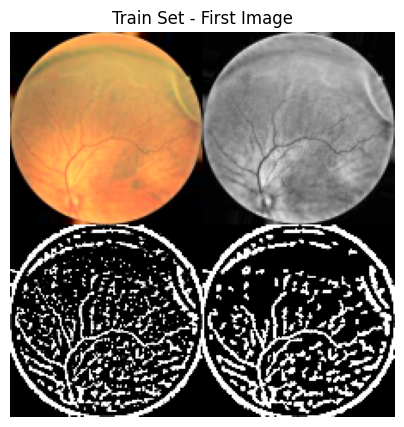

Found 549 images belonging to 3 classes.


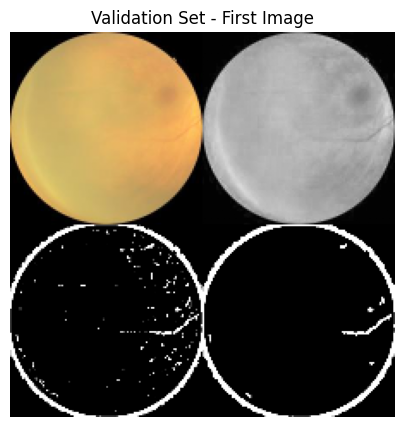

Found 275 images belonging to 3 classes.


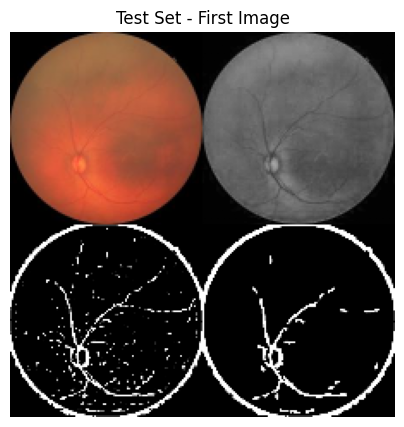

In [6]:
def display_one_image_from_generator(generator, title):
    # Fetch one batch of images and labels
    batch_images, batch_labels = next(generator)

    # Get the first image in the batch
    collage = batch_images[0]

    # Display the collage
    plt.figure(figsize=(5, 5))
    plt.imshow(collage)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display one image from the training set
display_one_image_from_generator(train_generator, "Train Set - First Image")

# Display one image from the validation set
display_one_image_from_generator(valid_generator, "Validation Set - First Image")

# Display one image from the test set
display_one_image_from_generator(test_generator, "Test Set - First Image")

In [ ]:
print("Collage shape:", collage.shape)
print("Collage dtype:", collage.dtype)
print("Collage min value:", np.min(collage))
print("Collage max value:", np.max(collage))

Collage shape: (224, 224, 3)
Collage dtype: uint8
Collage min value: 0
Collage max value: 255


## **Build and Compile the Model**

In [7]:
# Load DenseNet-121 base model
densenet_base = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    densenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 6,956,931 (26.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

## **Set Up Model Checkpoints**

In [8]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

## **Train the Model**

In [9]:
# Function to count the number of images in a directory
def count_images(directory):
    count = 0
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            count += len(os.listdir(class_path))
    return count

# Calculate the total number of images in the training and validation datasets
train_image_count = count_images(TRAIN_DIR)
valid_image_count = count_images(VALID_DIR)

# Calculate steps_per_epoch and validation_steps
train_steps = train_image_count // BATCH_SIZE
valid_steps = valid_image_count // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,  # Specify steps_per_epoch
    validation_data=valid_generator,
    validation_steps=valid_steps,  # Specify validation_steps
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7960 - auc: 0.9183 - loss: 0.5958 - precision: 0.8015 - recall: 0.7868   
Epoch 1: val_loss improved from inf to 0.66761, saving model to best_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.7966 - auc: 0.9187 - loss: 0.5943 - precision: 0.8020 - recall: 0.7875 - val_accuracy: 0.7718 - val_auc: 0.9224 - val_loss: 0.6676 - val_precision: 0.7718 - val_recall: 0.7718
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.9182 - auc: 0.9831 - loss: 0.2391 - precision: 0.9215 - recall: 0.9152
Epoch 2: val_loss did not improve from 0.66761
121/121 ━━━━━━━━━━━━━━━━━━━━ 96s 802ms/step - accuracy: 0.9182 - auc: 0.9831 - loss: 0.2392 - precision: 0.9215 - recall: 0.9152 - val_accuracy: 0.7757 - val_auc: 0.8666 - val_loss: 2.4151 - val_precision: 0.7757 - val_recall: 0.7757
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.9047 - auc: 0.9774 - loss: 0.2742 - precision: 0.9083 - reca

## **Plot Training History**

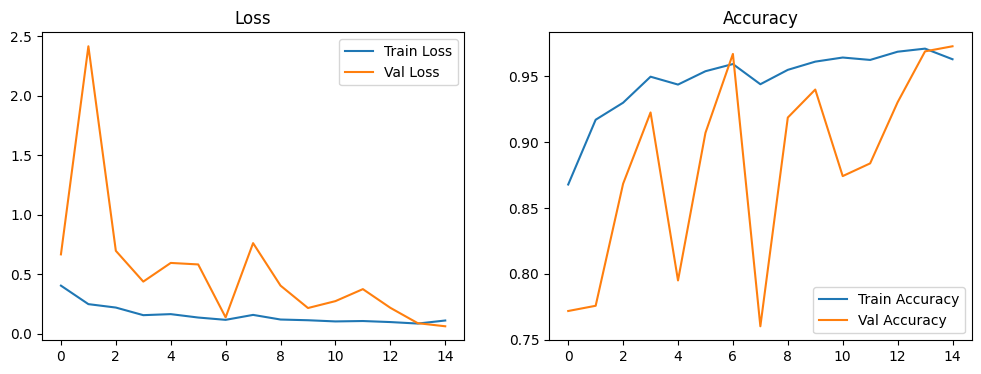

In [10]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate the Model on Test Data**

In [11]:
# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for evaluation
test_steps = test_image_count // BATCH_SIZE

# Evaluate on Test Data
model.load_weights('best_model.keras')
evaluation_metrics = model.evaluate(test_generator, steps=test_steps)  # Specify steps for evaluation

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9795 - auc: 0.9981 - loss: 0.0700 - precision: 0.9795 - recall: 0.9795
Test Loss: 0.0818
Test Accuracy: 0.9753
Test Precision: 0.9753
Test Recall: 0.9753
Test AUC: 0.9973


## **Generate Classification Report and Confusion Matrix**

8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step 

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.52      0.44      0.48        61
         ROP       0.81      0.85      0.83       179

    accuracy                           0.74       243
   macro avg       0.44      0.43      0.44       243
weighted avg       0.73      0.74      0.73       243


Confusion Matrix:
[[  0   0   3]
 [  1  27  33]
 [  2  25 152]]


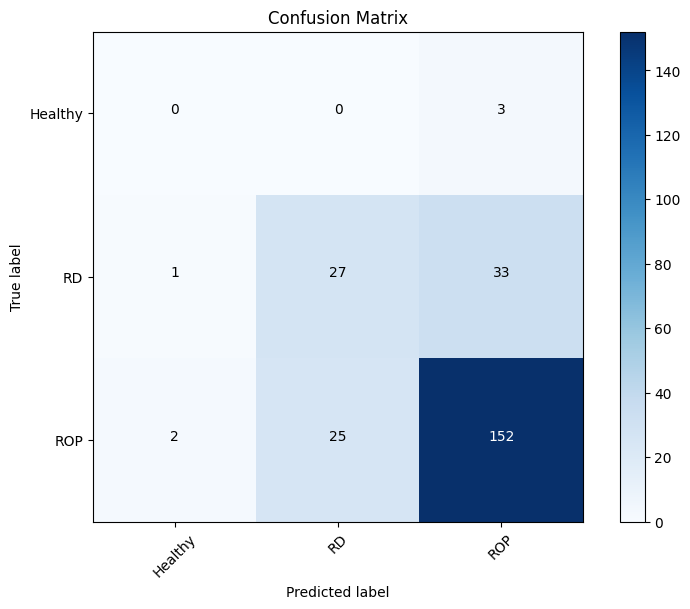

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to collect true labels from the generator
def collect_true_labels(generator, steps):
    y_true = []
    for _ in range(steps):
        _, batch_labels = next(generator)
        y_true.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot to class indices
    return np.array(y_true)

# Function to get class names from the dataset directory
def get_class_names(directory):
    return sorted(os.listdir(directory))

# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for prediction
test_steps = test_image_count // BATCH_SIZE

# Generate predictions with progress bar
predictions = model.predict(test_generator, steps=test_steps)  # Specify steps for prediction

# Collect true labels
y_true = collect_true_labels(test_generator, test_steps)

# Get predicted labels
y_pred = np.argmax(predictions, axis=1)

# Get class names
class_names = get_class_names(TEST_DIR)

# Identify unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate([y_true, y_pred]))

# Filter class names to include only the classes present in y_true and y_pred
filtered_class_names = [class_names[i] for i in unique_classes]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=filtered_class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(filtered_class_names))
plt.xticks(tick_marks, filtered_class_names, rotation=45)
plt.yticks(tick_marks, filtered_class_names)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [14]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"

os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'densenet_rop_model_vs1.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/saved_models/densenet_rop_model_vs1.h5


# **EfficientNetB0**

## **Imports and Setup**

In [11]:
import os
import numpy as np
import tensorflow as tf
import cv2
from skimage import morphology, measure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Dataset Paths and Parameters**

In [12]:
# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augumentation and Preprocessing**

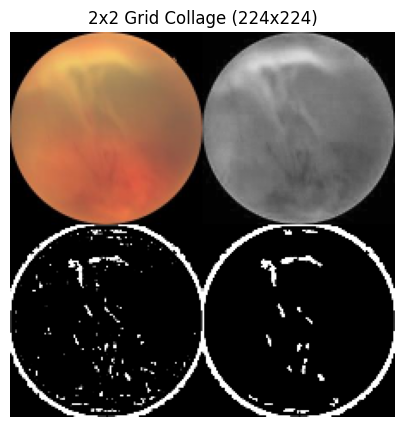

In [13]:
# Vessel Segmentation Function
def vessel_segmentation(image):
    # Step 1: Resize image
    resized_image = cv2.resize(image, (512, 512))

    # Step 2: Extract green channel and convert to uint8
    green_channel = resized_image[:, :, 1].astype(np.uint8)  # Ensure it's uint8

    # Step 3: Enhance using CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(green_channel)

    # Step 4: Apply adaptive thresholding and invert it
    adaptive_thresh_image = cv2.adaptiveThreshold(enhanced_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 25, 6)
    inverted_thresh_image = cv2.bitwise_not(adaptive_thresh_image)

    # Step 5: Apply median filtering to reduce noise
    median_filtered_image = cv2.medianBlur(inverted_thresh_image, 5)

    # Step 6: Apply morphological opening to remove small dots before dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened_image = cv2.morphologyEx(median_filtered_image, cv2.MORPH_OPEN, kernel)

    # Step 7: Apply morphological dilation with a smaller kernel size
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_image = cv2.dilate(opened_image, kernel)

    # Step 8: Remove small objects (increase min_size to remove smaller dots)
    labels = measure.label(dilated_image)
    cleaned = morphology.remove_small_objects(labels, min_size=100)
    final_image = (cleaned > 0).astype(np.uint8) * 255

    # Convert grayscale to 3-channel for visualization
    enhanced_image = cv2.merge([enhanced_image] * 3)
    inverted_thresh_image = cv2.merge([inverted_thresh_image] * 3)
    final_image = cv2.merge([final_image] * 3)

    return resized_image, enhanced_image, inverted_thresh_image, final_image

# Create 2x2 Grid Collage
def create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image):
    # Resize all images to half the size of the final collage (112x112)
    size = (112, 112)  # Each image will be 112x112
    resized_image = cv2.resize(resized_image, size)
    enhanced_image = cv2.resize(enhanced_image, size)
    inverted_thresh_image = cv2.resize(inverted_thresh_image, size)
    final_image = cv2.resize(final_image, size)

    # Create 2x2 grid
    top_row = np.hstack((resized_image, enhanced_image))  # Top row: Original + CLAHE
    bottom_row = np.hstack((inverted_thresh_image, final_image))  # Bottom row: Inverted + Final
    collage = np.vstack((top_row, bottom_row))  # Combine rows into 2x2 grid

    return collage

# Resize Collage to Target Size
def resize_collage(collage, target_size):

    return cv2.resize(collage, target_size)

# Get first image file in the training directory
first_class = os.listdir(TRAIN_DIR)[0]  # Get first class folder
first_class_path = os.path.join(TRAIN_DIR, first_class)
first_image_file = os.listdir(first_class_path)[2]  # Get first image file
first_image_path = os.path.join(first_class_path, first_image_file)

# Load the image
image = cv2.imread(first_image_path)

# Process the image and create the 2x2 collage
resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)

# Resize the collage to 224x224
collage = resize_collage(collage, (224, 224))

# Display the collage
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
plt.title("2x2 Grid Collage (224x224)")
plt.axis('off')
plt.show()

In [15]:
# Data Generators with Vessel Segmentation

# Custom Data Generator
def custom_data_generator(datagen, directory, target_size, batch_size, class_mode, shuffle=True):
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle  # Pass the shuffle argument
    )

    while True:
        batch_images, batch_labels = next(generator)

        collages = []
        for image in batch_images:
            # Ensure the image is in the correct format (uint8, [0, 255])
            if image.dtype != np.uint8:
                image = image.astype(np.uint8)

            # Process the image to create the collage
            resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
            collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)
            resized_collage = resize_collage(collage, target_size)
            # Rescale pixel values to [0, 1]
            resized_collage = resized_collage / 255.0
            collages.append(resized_collage)

        collages = np.array(collages)
        yield collages, batch_labels

# Preprocessing and Augmentation (without rescale)
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator()  # No rescale
test_datagen = ImageDataGenerator()   # No rescale

# Use the custom data generator
train_generator = custom_data_generator(train_datagen, TRAIN_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
valid_generator = custom_data_generator(valid_datagen, VALID_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
test_generator = custom_data_generator(test_datagen, TEST_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical', shuffle=False)

In [16]:
print("Collage shape:", collage.shape)
print("Collage dtype:", collage.dtype)
print("Collage min value:", np.min(collage))
print("Collage max value:", np.max(collage))

Collage shape: (224, 224, 3)
Collage dtype: uint8
Collage min value: 0
Collage max value: 255


## **Model Building**

In [17]:
# Build the Model
efficientnet_base = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    efficientnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes as per your dataset (e.g., 3 for Healthy, ROP, RD)
])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 4,011,391 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

## **Training**

In [18]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_rop_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Function to count the number of images in a directory
def count_images(directory):
    count = 0
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            count += len(os.listdir(class_path))
    return count

# Calculate the total number of images in the training and validation datasets
train_image_count = count_images(TRAIN_DIR)
valid_image_count = count_images(VALID_DIR)

# Calculate steps_per_epoch and validation_steps
train_steps = train_image_count // BATCH_SIZE
valid_steps = valid_image_count // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,  # Specify steps_per_epoch
    validation_data=valid_generator,
    validation_steps=valid_steps,  # Specify validation_steps
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Found 3877 images belonging to 3 classes.
Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.6812 - auc: 0.8473 - loss: 0.7142 - precision: 0.7712 - recall: 0.5486Found 549 images belonging to 3 classes.

Epoch 1: val_loss improved from inf to 1.69253, saving model to best_rop_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.6823 - auc: 0.8481 - loss: 0.7123 - precision: 0.7720 - recall: 0.5503 - val_accuracy: 0.2923 - val_auc: 0.2988 - val_loss: 1.6925 - val_precision: 0.2923 - val_recall: 0.2923
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.9391 - auc: 0.9903 - loss: 0.1869 - precision: 0.9424 - recall: 0.9349
Epoch 2: val_loss did not improve from 1.69253
121/121 ━━━━━━━━━━━━━━━━━━━━ 147s 928ms/step - accuracy: 0.9390 - auc: 0.9903 - loss: 0.1869 - precision: 0.9424 - recall: 0.9348 - val_accuracy: 0.2785 - val_auc: 0.2998 - val_loss: 2.2601 - val_precision: 0.2782 - val_recall: 0.2766
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 

## **Plot Training History**

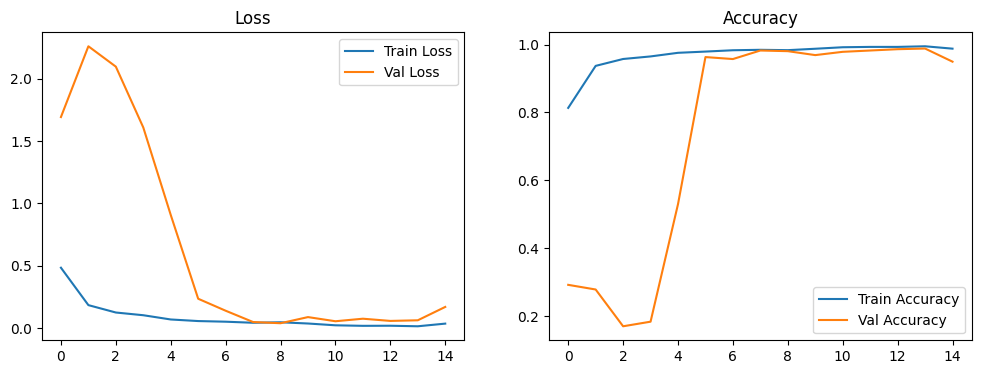

In [19]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluation on Test Data**

In [20]:
# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for evaluation
test_steps = test_image_count // BATCH_SIZE

# Evaluate on Test Data
model.load_weights('best_rop_model.keras')
evaluation_metrics = model.evaluate(test_generator, steps=test_steps)  # Specify steps for evaluation

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Found 275 images belonging to 3 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 544ms/step - accuracy: 0.9596 - auc: 0.9978 - loss: 0.1172 - precision: 0.9641 - recall: 0.9596
Test Loss: 0.0695
Test Accuracy: 0.9727
Test Precision: 0.9765
Test Recall: 0.9727
Test AUC: 0.9990


## **Classification Report and Confusion Matrix**

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 398ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.00      0.00      0.00        82
         ROP       0.67      1.00      0.80       171

    accuracy                           0.67       256
   macro avg       0.22      0.33      0.27       256
weighted avg       0.45      0.67      0.54       256


Confusion Matrix:
[[  0   0   3]
 [  0   0  82]
 [  0   0 171]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


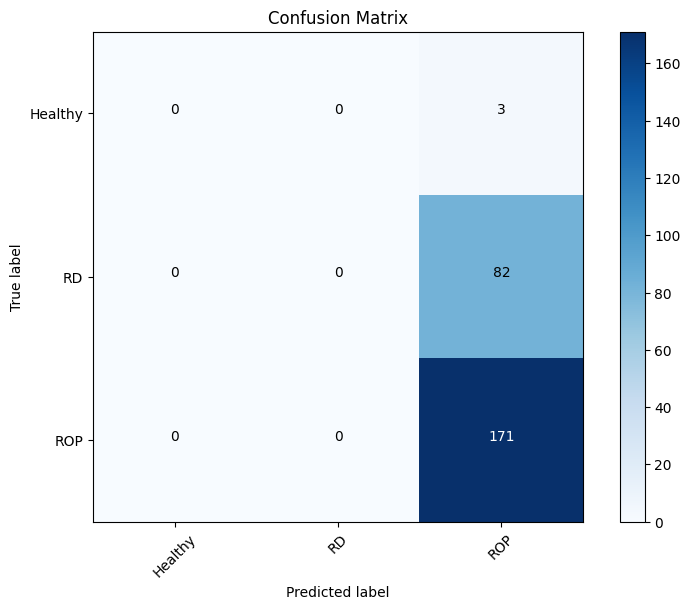

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to collect true labels from the generator
def collect_true_labels(generator, steps):
    y_true = []
    for _ in range(steps):
        _, batch_labels = next(generator)
        y_true.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot to class indices
    return np.array(y_true)

# Function to get class names from the dataset directory
def get_class_names(directory):
    return sorted(os.listdir(directory))

# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for prediction
test_steps = test_image_count // BATCH_SIZE

# Generate predictions with progress bar
predictions = model.predict(test_generator, steps=test_steps)  # Specify steps for prediction

# Collect true labels
y_true = collect_true_labels(test_generator, test_steps)

# Get predicted labels
y_pred = np.argmax(predictions, axis=1)

# Get class names
class_names = get_class_names(TEST_DIR)

# Identify unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate([y_true, y_pred]))

# Filter class names to include only the classes present in y_true and y_pred
filtered_class_names = [class_names[i] for i in unique_classes]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=filtered_class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(filtered_class_names))
plt.xticks(tick_marks, filtered_class_names, rotation=45)
plt.yticks(tick_marks, filtered_class_names)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [22]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'efficientnet_rop_model_vs1.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/saved_models/efficientnet_rop_model_vs1.h5


# **Xception**

## **Import Libraries and Set Up Parameters**


In [23]:
import os
import numpy as np
import tensorflow as tf
import cv2
from skimage import morphology, measure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augmentation and Preprocessing**

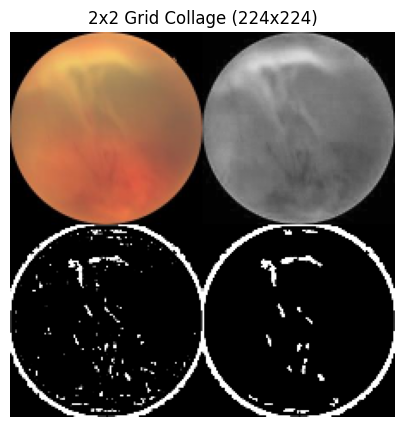

In [24]:
# Vessel Segmentation Function
def vessel_segmentation(image):
    # Step 1: Resize image
    resized_image = cv2.resize(image, (512, 512))

    # Step 2: Extract green channel and convert to uint8
    green_channel = resized_image[:, :, 1].astype(np.uint8)  # Ensure it's uint8

    # Step 3: Enhance using CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(green_channel)

    # Step 4: Apply adaptive thresholding and invert it
    adaptive_thresh_image = cv2.adaptiveThreshold(enhanced_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 25, 6)
    inverted_thresh_image = cv2.bitwise_not(adaptive_thresh_image)

    # Step 5: Apply median filtering to reduce noise
    median_filtered_image = cv2.medianBlur(inverted_thresh_image, 5)

    # Step 6: Apply morphological opening to remove small dots before dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened_image = cv2.morphologyEx(median_filtered_image, cv2.MORPH_OPEN, kernel)

    # Step 7: Apply morphological dilation with a smaller kernel size
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_image = cv2.dilate(opened_image, kernel)

    # Step 8: Remove small objects (increase min_size to remove smaller dots)
    labels = measure.label(dilated_image)
    cleaned = morphology.remove_small_objects(labels, min_size=100)
    final_image = (cleaned > 0).astype(np.uint8) * 255

    # Convert grayscale to 3-channel for visualization
    enhanced_image = cv2.merge([enhanced_image] * 3)
    inverted_thresh_image = cv2.merge([inverted_thresh_image] * 3)
    final_image = cv2.merge([final_image] * 3)

    return resized_image, enhanced_image, inverted_thresh_image, final_image

# Create 2x2 Grid Collage
def create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image):
    # Resize all images to half the size of the final collage (112x112)
    size = (112, 112)  # Each image will be 112x112
    resized_image = cv2.resize(resized_image, size)
    enhanced_image = cv2.resize(enhanced_image, size)
    inverted_thresh_image = cv2.resize(inverted_thresh_image, size)
    final_image = cv2.resize(final_image, size)

    # Create 2x2 grid
    top_row = np.hstack((resized_image, enhanced_image))  # Top row: Original + CLAHE
    bottom_row = np.hstack((inverted_thresh_image, final_image))  # Bottom row: Inverted + Final
    collage = np.vstack((top_row, bottom_row))  # Combine rows into 2x2 grid

    return collage

# Resize Collage to Target Size
def resize_collage(collage, target_size):

    return cv2.resize(collage, target_size)

# Get first image file in the training directory
first_class = os.listdir(TRAIN_DIR)[0]  # Get first class folder
first_class_path = os.path.join(TRAIN_DIR, first_class)
first_image_file = os.listdir(first_class_path)[2]  # Get first image file
first_image_path = os.path.join(first_class_path, first_image_file)

# Load the image
image = cv2.imread(first_image_path)

# Process the image and create the 2x2 collage
resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)

# Resize the collage to 224x224
collage = resize_collage(collage, (224, 224))

# Display the collage
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
plt.title("2x2 Grid Collage (224x224)")
plt.axis('off')
plt.show()

In [25]:
# Data Generators with Vessel Segmentation

# Custom Data Generator
def custom_data_generator(datagen, directory, target_size, batch_size, class_mode, shuffle=True):
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle  # Pass the shuffle argument
    )

    while True:
        batch_images, batch_labels = next(generator)

        collages = []
        for image in batch_images:
            # Ensure the image is in the correct format (uint8, [0, 255])
            if image.dtype != np.uint8:
                image = image.astype(np.uint8)

            # Process the image to create the collage
            resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
            collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)
            resized_collage = resize_collage(collage, target_size)
            # Rescale pixel values to [0, 1]
            resized_collage = resized_collage / 255.0
            collages.append(resized_collage)

        collages = np.array(collages)
        yield collages, batch_labels

# Preprocessing and Augmentation (without rescale)
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator()  # No rescale
test_datagen = ImageDataGenerator()   # No rescale

# Use the custom data generator
train_generator = custom_data_generator(train_datagen, TRAIN_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
valid_generator = custom_data_generator(valid_datagen, VALID_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
test_generator = custom_data_generator(test_datagen, TEST_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical', shuffle=False)

## **Build the Model**

In [26]:
# Build the Model
xception_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    xception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust for your number of classes
])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 20,813,099 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

## **Train the Model**

In [27]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_xception_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Function to count the number of images in a directory
def count_images(directory):
    count = 0
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            count += len(os.listdir(class_path))
    return count

# Calculate the total number of images in the training and validation datasets
train_image_count = count_images(TRAIN_DIR)
valid_image_count = count_images(VALID_DIR)

# Calculate steps_per_epoch and validation_steps
train_steps = train_image_count // BATCH_SIZE
valid_steps = valid_image_count // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,  # Specify steps_per_epoch
    validation_data=valid_generator,
    validation_steps=valid_steps,  # Specify validation_steps
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Found 3877 images belonging to 3 classes.
Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.7549 - auc: 0.8901 - loss: 0.5935 - precision: 0.8584 - recall: 0.5896Found 549 images belonging to 3 classes.

Epoch 1: val_loss improved from inf to 0.46023, saving model to best_xception_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 157s 904ms/step - accuracy: 0.7559 - auc: 0.8908 - loss: 0.5915 - precision: 0.8590 - recall: 0.5914 - val_accuracy: 0.8327 - val_auc: 0.9627 - val_loss: 0.4602 - val_precision: 0.8321 - val_recall: 0.8290
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.9603 - auc: 0.9962 - loss: 0.1133 - precision: 0.9625 - recall: 0.9594
Epoch 2: val_loss improved from 0.46023 to 0.10659, saving model to best_xception_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 120s 856ms/step - accuracy: 0.9603 - auc: 0.9962 - loss: 0.1132 - precision: 0.9626 - recall: 0.9594 - val_accuracy: 0.9632 - val_auc: 0.9945 - val_loss: 0.1066 - val_precision: 0.9670 - val_

## **Plot Training History**

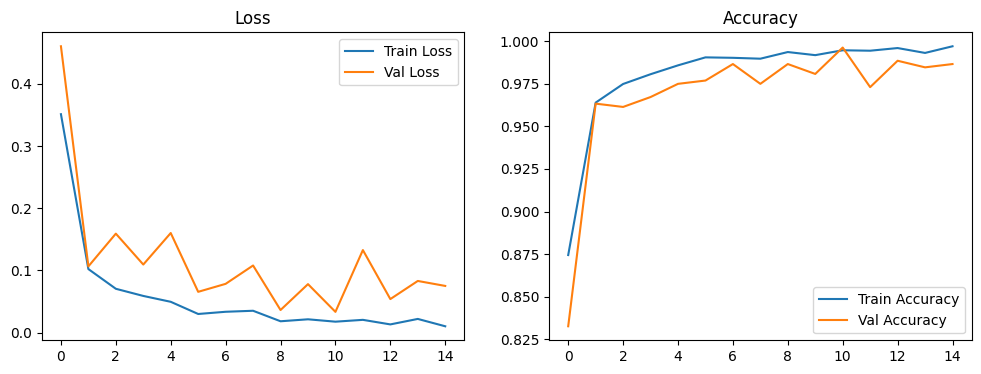

In [28]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate the Model**

In [29]:
# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for evaluation
test_steps = test_image_count // BATCH_SIZE

# Evaluate the Model
model.load_weights('best_xception_model.keras')

evaluation_metrics = model.evaluate(test_generator, steps=test_steps)  # Specify steps for evaluation

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Found 275 images belonging to 3 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.9965 - auc: 1.0000 - loss: 0.0133 - precision: 0.9965 - recall: 0.9965
Test Loss: 0.0138
Test Accuracy: 0.9961
Test Precision: 0.9961
Test Recall: 0.9961
Test AUC: 1.0000


## **Classification Report and Confusion Matrix**

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00         3
          RD       0.99      1.00      0.99        82
         ROP       1.00      0.99      1.00       171

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256


Confusion Matrix:
[[  3   0   0]
 [  0  82   0]
 [  0   1 170]]


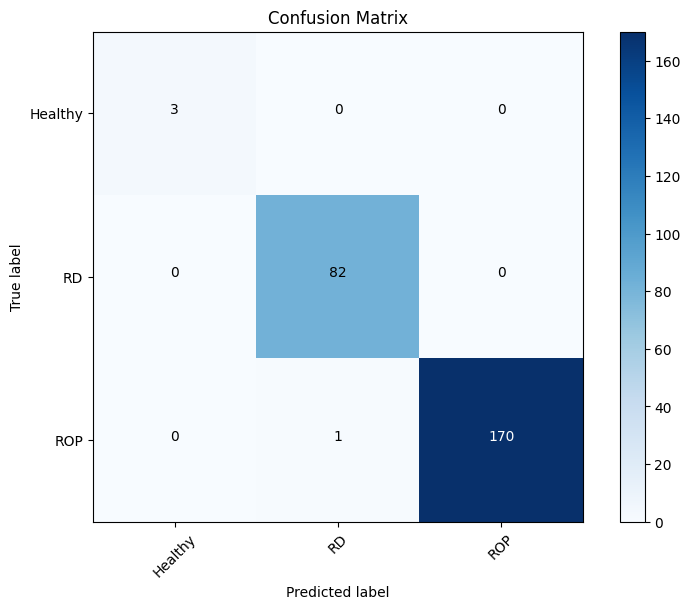

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to collect true labels from the generator
def collect_true_labels(generator, steps):
    y_true = []
    for _ in range(steps):
        _, batch_labels = next(generator)
        y_true.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot to class indices
    return np.array(y_true)

# Function to get class names from the dataset directory
def get_class_names(directory):
    return sorted(os.listdir(directory))

# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for prediction
test_steps = test_image_count // BATCH_SIZE

# Generate predictions with progress bar
predictions = model.predict(test_generator, steps=test_steps)  # Specify steps for prediction

# Collect true labels
y_true = collect_true_labels(test_generator, test_steps)

# Get predicted labels
y_pred = np.argmax(predictions, axis=1)

# Get class names
class_names = get_class_names(TEST_DIR)

# Identify unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate([y_true, y_pred]))

# Filter class names to include only the classes present in y_true and y_pred
filtered_class_names = [class_names[i] for i in unique_classes]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=filtered_class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(filtered_class_names))
plt.xticks(tick_marks, filtered_class_names, rotation=45)
plt.yticks(tick_marks, filtered_class_names)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [31]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'xception_rop_model_vs1.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/saved_models/xception_rop_model_vs1.h5


# **InceptionV3**

## **Import Libraries and Set Up Parameters**


In [24]:
import os
import numpy as np
import tensorflow as tf
import cv2
from skimage import morphology, measure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augmentation and Preprocessing**

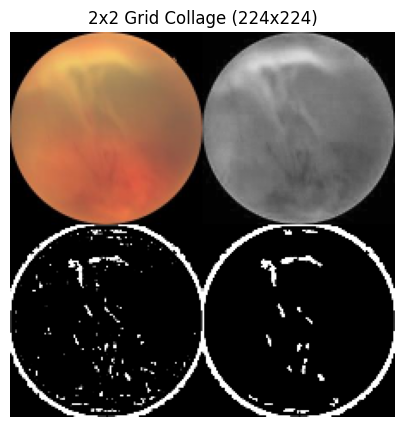

In [27]:
# Vessel Segmentation Function
def vessel_segmentation(image):
    # Step 1: Resize image
    resized_image = cv2.resize(image, (512, 512))

    # Step 2: Extract green channel and convert to uint8
    green_channel = resized_image[:, :, 1].astype(np.uint8)  # Ensure it's uint8

    # Step 3: Enhance using CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(green_channel)

    # Step 4: Apply adaptive thresholding and invert it
    adaptive_thresh_image = cv2.adaptiveThreshold(enhanced_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 25, 6)
    inverted_thresh_image = cv2.bitwise_not(adaptive_thresh_image)

    # Step 5: Apply median filtering to reduce noise
    median_filtered_image = cv2.medianBlur(inverted_thresh_image, 5)

    # Step 6: Apply morphological opening to remove small dots before dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened_image = cv2.morphologyEx(median_filtered_image, cv2.MORPH_OPEN, kernel)

    # Step 7: Apply morphological dilation with a smaller kernel size
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_image = cv2.dilate(opened_image, kernel)

    # Step 8: Remove small objects (increase min_size to remove smaller dots)
    labels = measure.label(dilated_image)
    cleaned = morphology.remove_small_objects(labels, min_size=100)
    final_image = (cleaned > 0).astype(np.uint8) * 255

    # Convert grayscale to 3-channel for visualization
    enhanced_image = cv2.merge([enhanced_image] * 3)
    inverted_thresh_image = cv2.merge([inverted_thresh_image] * 3)
    final_image = cv2.merge([final_image] * 3)

    return resized_image, enhanced_image, inverted_thresh_image, final_image

# Create 2x2 Grid Collage
def create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image):
    # Resize all images to half the size of the final collage (112x112)
    size = (112, 112)  # Each image will be 112x112
    resized_image = cv2.resize(resized_image, size)
    enhanced_image = cv2.resize(enhanced_image, size)
    inverted_thresh_image = cv2.resize(inverted_thresh_image, size)
    final_image = cv2.resize(final_image, size)

    # Create 2x2 grid
    top_row = np.hstack((resized_image, enhanced_image))  # Top row: Original + CLAHE
    bottom_row = np.hstack((inverted_thresh_image, final_image))  # Bottom row: Inverted + Final
    collage = np.vstack((top_row, bottom_row))  # Combine rows into 2x2 grid

    return collage

# Resize Collage to Target Size
def resize_collage(collage, target_size):

    return cv2.resize(collage, target_size)

# Get first image file in the training directory
first_class = os.listdir(TRAIN_DIR)[0]  # Get first class folder
first_class_path = os.path.join(TRAIN_DIR, first_class)
first_image_file = os.listdir(first_class_path)[2]  # Get first image file
first_image_path = os.path.join(first_class_path, first_image_file)

# Load the image
image = cv2.imread(first_image_path)

# Process the image and create the 2x2 collage
resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)

# Resize the collage to 224x224
collage = resize_collage(collage, (224, 224))

# Display the collage
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
plt.title("2x2 Grid Collage (224x224)")
plt.axis('off')
plt.show()

In [28]:
# Data Generators with Vessel Segmentation

# Custom Data Generator
def custom_data_generator(datagen, directory, target_size, batch_size, class_mode, shuffle=True):
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle  # Pass the shuffle argument
    )

    while True:
        batch_images, batch_labels = next(generator)

        collages = []
        for image in batch_images:
            # Ensure the image is in the correct format (uint8, [0, 255])
            if image.dtype != np.uint8:
                image = image.astype(np.uint8)

            # Process the image to create the collage
            resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
            collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)
            resized_collage = resize_collage(collage, target_size)
            # Rescale pixel values to [0, 1]
            resized_collage = resized_collage / 255.0
            collages.append(resized_collage)

        collages = np.array(collages)
        yield collages, batch_labels

# Preprocessing and Augmentation (without rescale)
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator()  # No rescale
test_datagen = ImageDataGenerator()   # No rescale

# Use the custom data generator
train_generator = custom_data_generator(train_datagen, TRAIN_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
valid_generator = custom_data_generator(valid_datagen, VALID_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
test_generator = custom_data_generator(test_datagen, TEST_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical', shuffle=False)

## **Build Model**

In [29]:
inception_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    inception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model with additional metrics
model.compile(
    optimizer="adam",  # or any optimizer of your choice
    loss="categorical_crossentropy",  # or any loss function suitable for your problem
    metrics=[
        "accuracy",  # default metric
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

# Display the model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 21,774,499 (83.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

## **Train Model**

In [30]:
checkpoint = ModelCheckpoint(
    'best_inception_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Function to count the number of images in a directory
def count_images(directory):
    count = 0
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            count += len(os.listdir(class_path))
    return count

# Calculate the total number of images in the training and validation datasets
train_image_count = count_images(TRAIN_DIR)
valid_image_count = count_images(VALID_DIR)

# Calculate steps_per_epoch and validation_steps
train_steps = train_image_count // BATCH_SIZE
valid_steps = valid_image_count // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,  # Specify steps_per_epoch
    validation_data=valid_generator,
    validation_steps=valid_steps,  # Specify validation_steps
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Found 3877 images belonging to 3 classes.
Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.8109 - auc: 0.9299 - loss: 0.4906 - precision: 0.8279 - recall: 0.7937Found 549 images belonging to 3 classes.

Epoch 1: val_loss improved from inf to 0.51809, saving model to best_inception_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 168s 887ms/step - accuracy: 0.8114 - auc: 0.9302 - loss: 0.4894 - precision: 0.8284 - recall: 0.7944 - val_accuracy: 0.9062 - val_auc: 0.9648 - val_loss: 0.5181 - val_precision: 0.9062 - val_recall: 0.9062
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.9269 - auc: 0.9862 - loss: 0.2095 - precision: 0.9289 - recall: 0.9252
Epoch 2: val_loss improved from 0.51809 to 0.22251, saving model to best_inception_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 125s 824ms/step - accuracy: 0.9269 - auc: 0.9862 - loss: 0.2096 - precision: 0.9290 - recall: 0.9252 - val_accuracy: 0.9400 - val_auc: 0.9873 - val_loss: 0.2225 - val_precision: 0.9399 - va

## **Plotting Training History**

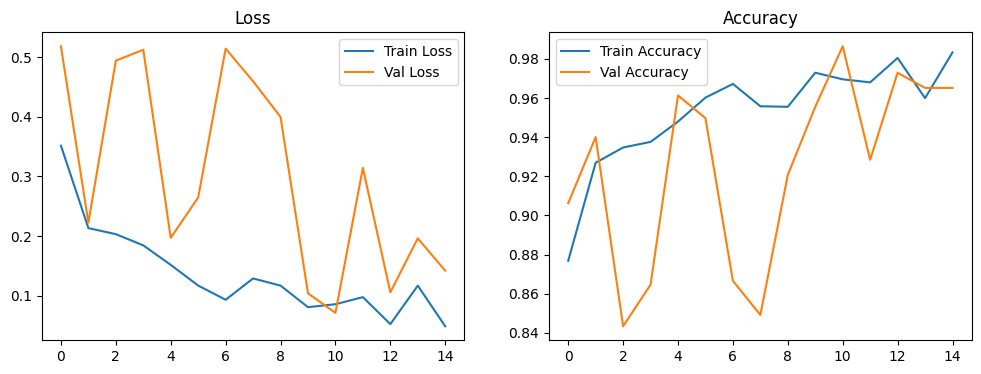

In [31]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate on Test data**

In [32]:
# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for evaluation
test_steps = test_image_count // BATCH_SIZE

# Evaluate on Test Data
model.load_weights('best_inception_model.keras')
evaluation_metrics = model.evaluate(test_generator, steps=test_steps)  # Specify steps for evaluation

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Found 275 images belonging to 3 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.9605 - auc: 0.9973 - loss: 0.0879 - precision: 0.9605 - recall: 0.9605
Test Loss: 0.0429
Test Accuracy: 0.9844
Test Precision: 0.9844
Test Recall: 0.9844
Test AUC: 0.9995


## **Classification Report and Confusion Matrix**

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 373ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.67      0.80         3
          RD       1.00      0.96      0.98        82
         ROP       0.98      1.00      0.99       171

    accuracy                           0.98       256
   macro avg       0.99      0.88      0.92       256
weighted avg       0.98      0.98      0.98       256


Confusion Matrix:
[[  2   0   1]
 [  0  79   3]
 [  0   0 171]]


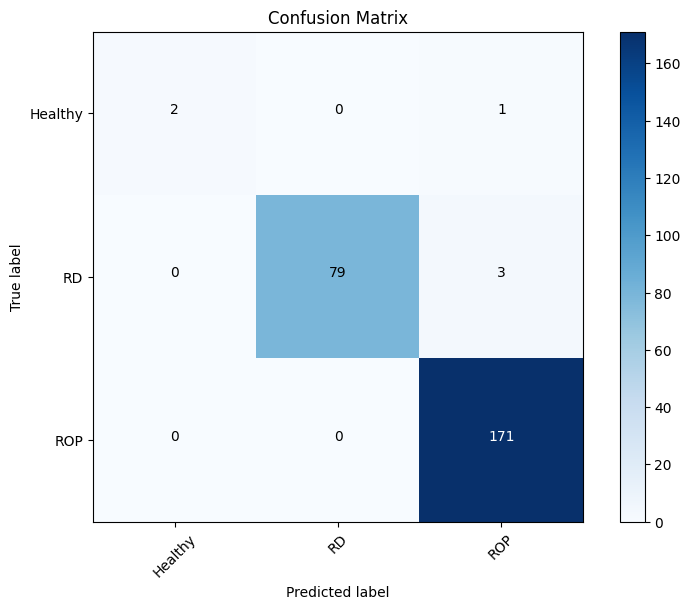

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to collect true labels from the generator
def collect_true_labels(generator, steps):
    y_true = []
    for _ in range(steps):
        _, batch_labels = next(generator)
        y_true.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot to class indices
    return np.array(y_true)

# Function to get class names from the dataset directory
def get_class_names(directory):
    return sorted(os.listdir(directory))

# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for prediction
test_steps = test_image_count // BATCH_SIZE

# Generate predictions with progress bar
predictions = model.predict(test_generator, steps=test_steps)  # Specify steps for prediction

# Collect true labels
y_true = collect_true_labels(test_generator, test_steps)

# Get predicted labels
y_pred = np.argmax(predictions, axis=1)

# Get class names
class_names = get_class_names(TEST_DIR)

# Identify unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate([y_true, y_pred]))

# Filter class names to include only the classes present in y_true and y_pred
filtered_class_names = [class_names[i] for i in unique_classes]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=filtered_class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(filtered_class_names))
plt.xticks(tick_marks, filtered_class_names, rotation=45)
plt.yticks(tick_marks, filtered_class_names)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [34]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'inceptionv3_rop_model_vs1.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/inceptionv3_rop_model_vs1.h5


# **MobileNetV3**

## **Import Libraries and Set Up Parameters**



In [14]:
import os
import numpy as np
import tensorflow as tf
import cv2
from skimage import morphology, measure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV3Large
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augmentation and Preprocessing**

In [16]:
# Data Generators with Vessel Segmentation

# Custom Data Generator
def custom_data_generator(datagen, directory, target_size, batch_size, class_mode, shuffle=True):
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle  # Pass the shuffle argument
    )

    while True:
        batch_images, batch_labels = next(generator)

        collages = []
        for image in batch_images:
            # Ensure the image is in the correct format (uint8, [0, 255])
            if image.dtype != np.uint8:
                image = image.astype(np.uint8)

            # Process the image to create the collage
            resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
            collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)
            resized_collage = resize_collage(collage, target_size)
            # Rescale pixel values to [0, 1]
            resized_collage = resized_collage / 255.0
            collages.append(resized_collage)

        collages = np.array(collages)
        yield collages, batch_labels

# Preprocessing and Augmentation (without rescale)
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator()  # No rescale
test_datagen = ImageDataGenerator()   # No rescale

# Use the custom data generator
train_generator = custom_data_generator(train_datagen, TRAIN_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
valid_generator = custom_data_generator(valid_datagen, VALID_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
test_generator = custom_data_generator(test_datagen, TEST_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical', shuffle=False)

## **Build Model**

In [17]:
mobilenetv3_base = MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    mobilenetv3_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()




12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           2,883 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,999,235 (11.44 MB)

 Trainable params: 2,974,835 (11.35 MB)

 Non-trainable params: 24,400 (95.31 KB)

## **Train the Model**

In [18]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_mobilenetv3_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
# Function to count the number of images in a directory
def count_images(directory):
    count = 0
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            count += len(os.listdir(class_path))
    return count

# Calculate the total number of images in the training and validation datasets
train_image_count = count_images(TRAIN_DIR)
valid_image_count = count_images(VALID_DIR)

# Calculate steps_per_epoch and validation_steps
train_steps = train_image_count // BATCH_SIZE
valid_steps = valid_image_count // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,  # Specify steps_per_epoch
    validation_data=valid_generator,
    validation_steps=valid_steps,  # Specify validation_steps
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Found 3877 images belonging to 3 classes.
Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.5842 - auc: 0.7551 - loss: 1.0380 - precision: 0.5946 - recall: 0.5560Found 549 images belonging to 3 classes.

Epoch 1: val_loss improved from inf to 1.73870, saving model to best_mobilenetv3_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 162s 906ms/step - accuracy: 0.5857 - auc: 0.7564 - loss: 1.0343 - precision: 0.5961 - recall: 0.5575 - val_accuracy: 0.2812 - val_auc: 0.2682 - val_loss: 1.7387 - val_precision: 0.2131 - val_recall: 0.0956
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.9186 - auc: 0.9822 - loss: 0.2408 - precision: 0.9226 - recall: 0.9157
Epoch 2: val_loss improved from 1.73870 to 1.60776, saving model to best_mobilenetv3_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 127s 859ms/step - accuracy: 0.9187 - auc: 0.9823 - loss: 0.2407 - precision: 0.9226 - recall: 0.9157 - val_accuracy: 0.2824 - val_auc: 0.2622 - val_loss: 1.6078 - val_precision: 0.2094 

## **Plotting Training History**

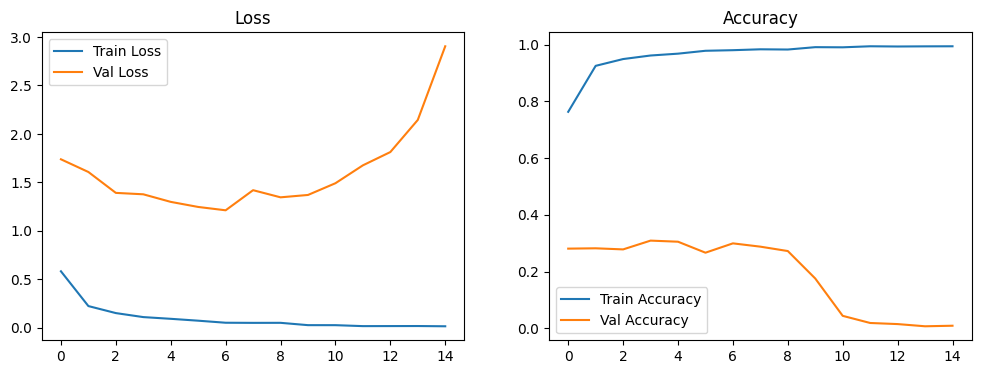

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate on Test Data**

In [20]:
# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for evaluation
test_steps = test_image_count // BATCH_SIZE

# Evaluate on Test Data
model.load_weights('best_mobilenetv3_model.keras')
evaluation_metrics = model.evaluate(test_generator, steps=test_steps)  # Specify steps for evaluation

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Calculate and print mean training accuracy
mean_train_accuracy = np.mean(history.history['accuracy'])
print(f"Mean Training Accuracy: {mean_train_accuracy:.4f}")

# Calculate and print mean validation accuracy
mean_val_accuracy = np.mean(history.history['val_accuracy'])
print(f"Mean Validation Accuracy: {mean_val_accuracy:.4f}")

Found 275 images belonging to 3 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 388ms/step - accuracy: 0.5889 - auc: 0.6249 - loss: 1.0099 - precision: 0.6043 - recall: 0.2529
Test Loss: 1.2020
Test Accuracy: 0.3203
Test Precision: 0.3711
Test Recall: 0.1406
Test AUC: 0.3923
Mean Training Accuracy: 0.9632
Mean Validation Accuracy: 0.1905


## **Classification Report and Confusion Matrix**

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 361ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.32      1.00      0.49        82
         ROP       0.00      0.00      0.00       171

    accuracy                           0.32       256
   macro avg       0.11      0.33      0.16       256
weighted avg       0.10      0.32      0.16       256


Confusion Matrix:
[[  0   3   0]
 [  0  82   0]
 [  0 171   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


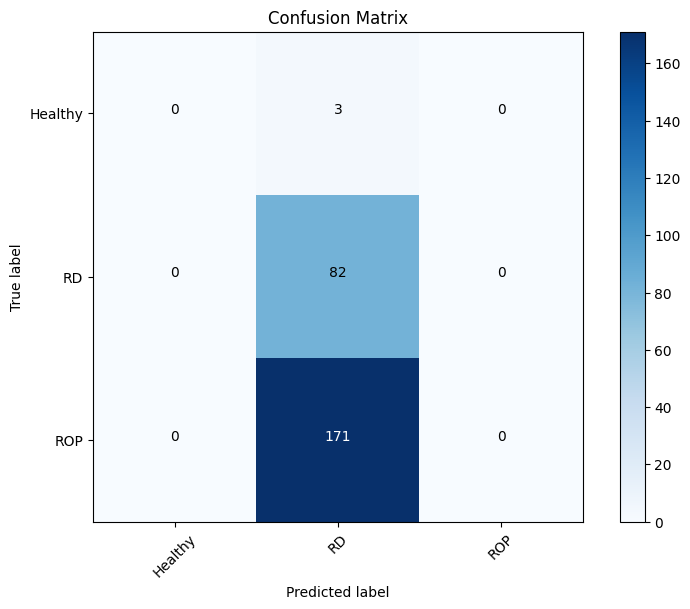

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to collect true labels from the generator
def collect_true_labels(generator, steps):
    y_true = []
    for _ in range(steps):
        _, batch_labels = next(generator)
        y_true.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot to class indices
    return np.array(y_true)

# Function to get class names from the dataset directory
def get_class_names(directory):
    return sorted(os.listdir(directory))

# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for prediction
test_steps = test_image_count // BATCH_SIZE

# Generate predictions with progress bar
predictions = model.predict(test_generator, steps=test_steps)  # Specify steps for prediction

# Collect true labels
y_true = collect_true_labels(test_generator, test_steps)

# Get predicted labels
y_pred = np.argmax(predictions, axis=1)

# Get class names
class_names = get_class_names(TEST_DIR)

# Identify unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate([y_true, y_pred]))

# Filter class names to include only the classes present in y_true and y_pred
filtered_class_names = [class_names[i] for i in unique_classes]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=filtered_class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(filtered_class_names))
plt.xticks(tick_marks, filtered_class_names, rotation=45)
plt.yticks(tick_marks, filtered_class_names)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [22]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'mobilenetv3_rop_model_vs1.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/mobilenetv3_rop_model_vs1.h5


# **VGG16**


## **Import Libraries and Set Up parameters**

In [3]:
import os
import numpy as np
import tensorflow as tf
import cv2
from skimage import morphology, measure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augmentation and Preprocessing**

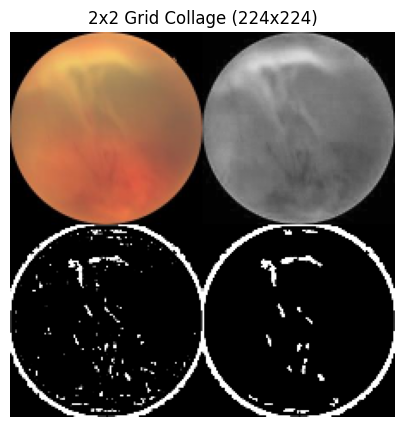

In [4]:
# Vessel Segmentation Function
def vessel_segmentation(image):
    # Step 1: Resize image
    resized_image = cv2.resize(image, (512, 512))

    # Step 2: Extract green channel and convert to uint8
    green_channel = resized_image[:, :, 1].astype(np.uint8)  # Ensure it's uint8

    # Step 3: Enhance using CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(green_channel)

    # Step 4: Apply adaptive thresholding and invert it
    adaptive_thresh_image = cv2.adaptiveThreshold(enhanced_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 25, 6)
    inverted_thresh_image = cv2.bitwise_not(adaptive_thresh_image)

    # Step 5: Apply median filtering to reduce noise
    median_filtered_image = cv2.medianBlur(inverted_thresh_image, 5)

    # Step 6: Apply morphological opening to remove small dots before dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened_image = cv2.morphologyEx(median_filtered_image, cv2.MORPH_OPEN, kernel)

    # Step 7: Apply morphological dilation with a smaller kernel size
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_image = cv2.dilate(opened_image, kernel)

    # Step 8: Remove small objects (increase min_size to remove smaller dots)
    labels = measure.label(dilated_image)
    cleaned = morphology.remove_small_objects(labels, min_size=100)
    final_image = (cleaned > 0).astype(np.uint8) * 255

    # Convert grayscale to 3-channel for visualization
    enhanced_image = cv2.merge([enhanced_image] * 3)
    inverted_thresh_image = cv2.merge([inverted_thresh_image] * 3)
    final_image = cv2.merge([final_image] * 3)

    return resized_image, enhanced_image, inverted_thresh_image, final_image

# Create 2x2 Grid Collage
def create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image):
    # Resize all images to half the size of the final collage (112x112)
    size = (112, 112)  # Each image will be 112x112
    resized_image = cv2.resize(resized_image, size)
    enhanced_image = cv2.resize(enhanced_image, size)
    inverted_thresh_image = cv2.resize(inverted_thresh_image, size)
    final_image = cv2.resize(final_image, size)

    # Create 2x2 grid
    top_row = np.hstack((resized_image, enhanced_image))  # Top row: Original + CLAHE
    bottom_row = np.hstack((inverted_thresh_image, final_image))  # Bottom row: Inverted + Final
    collage = np.vstack((top_row, bottom_row))  # Combine rows into 2x2 grid

    return collage

# Resize Collage to Target Size
def resize_collage(collage, target_size):

    return cv2.resize(collage, target_size)

# Get first image file in the training directory
first_class = os.listdir(TRAIN_DIR)[0]  # Get first class folder
first_class_path = os.path.join(TRAIN_DIR, first_class)
first_image_file = os.listdir(first_class_path)[2]  # Get first image file
first_image_path = os.path.join(first_class_path, first_image_file)

# Load the image
image = cv2.imread(first_image_path)

# Process the image and create the 2x2 collage
resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)

# Resize the collage to 224x224
collage = resize_collage(collage, (224, 224))

# Display the collage
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
plt.title("2x2 Grid Collage (224x224)")
plt.axis('off')
plt.show()

In [5]:
# Data Generators with Vessel Segmentation

# Custom Data Generator
def custom_data_generator(datagen, directory, target_size, batch_size, class_mode, shuffle=True):
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle  # Pass the shuffle argument
    )

    while True:
        batch_images, batch_labels = next(generator)

        collages = []
        for image in batch_images:
            # Ensure the image is in the correct format (uint8, [0, 255])
            if image.dtype != np.uint8:
                image = image.astype(np.uint8)

            # Process the image to create the collage
            resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
            collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)
            resized_collage = resize_collage(collage, target_size)
            # Rescale pixel values to [0, 1]
            resized_collage = resized_collage / 255.0
            collages.append(resized_collage)

        collages = np.array(collages)
        yield collages, batch_labels

# Preprocessing and Augmentation (without rescale)
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator()  # No rescale
test_datagen = ImageDataGenerator()   # No rescale

# Use the custom data generator
train_generator = custom_data_generator(train_datagen, TRAIN_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
valid_generator = custom_data_generator(valid_datagen, VALID_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
test_generator = custom_data_generator(test_datagen, TEST_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical', shuffle=False)

## **Build the Model**

In [6]:
vgg_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze the base model layers
vgg_base.trainable = False

# Add custom layers on top
model = Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model
model.compile(
    optimizer="adam",  # Can experiment with other optimizers like SGD
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,716,227 (56.14 MB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## **Train the Model**

In [7]:
checkpoint = ModelCheckpoint(
    'best_vgg_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Function to count the number of images in a directory
def count_images(directory):
    count = 0
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            count += len(os.listdir(class_path))
    return count

# Calculate the total number of images in the training and validation datasets
train_image_count = count_images(TRAIN_DIR)
valid_image_count = count_images(VALID_DIR)

# Calculate steps_per_epoch and validation_steps
train_steps = train_image_count // BATCH_SIZE
valid_steps = valid_image_count // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,  # Specify steps_per_epoch
    validation_data=valid_generator,
    validation_steps=valid_steps,  # Specify validation_steps
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Found 3877 images belonging to 3 classes.
Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.6160 - auc: 0.8002 - loss: 0.8006 - precision: 0.6253 - recall: 0.5673Found 549 images belonging to 3 classes.

Epoch 1: val_loss improved from inf to 0.59801, saving model to best_vgg_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.6165 - auc: 0.8007 - loss: 0.7998 - precision: 0.6258 - recall: 0.5681 - val_accuracy: 0.6985 - val_auc: 0.9162 - val_loss: 0.5980 - val_precision: 0.6985 - val_recall: 0.6985
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.7294 - auc: 0.8900 - loss: 0.6086 - precision: 0.7307 - recall: 0.7255
Epoch 2: val_loss improved from 0.59801 to 0.55509, saving model to best_vgg_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 100s 809ms/step - accuracy: 0.7293 - auc: 0.8900 - loss: 0.6085 - precision: 0.7307 - recall: 0.7255 - val_accuracy: 0.7118 - val_auc: 0.9214 - val_loss: 0.5551 - val_precision: 0.7118 - val_recall: 0.711

## **Plotting training History**

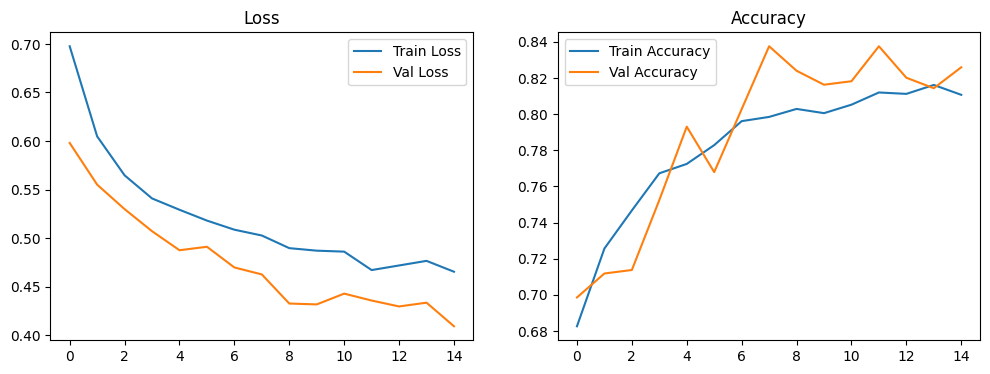

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


## **Evaluate on Test Data**

In [9]:
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for evaluation
test_steps = test_image_count // BATCH_SIZE

# Evaluate on Test Data
model.load_weights('best_vgg_model.keras')
evaluation_metrics = model.evaluate(test_generator, steps=test_steps)  # Specify steps for evaluation

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")


# Calculate and print mean training accuracy
mean_train_accuracy = np.mean(history.history['accuracy'])
print(f"Mean Training Accuracy: {mean_train_accuracy:.4f}")

# Calculate and print mean validation accuracy
mean_val_accuracy = np.mean(history.history['val_accuracy'])
print(f"Mean Validation Accuracy: {mean_val_accuracy:.4f}")
# Calculate the total number of images in the test dataset

Found 275 images belonging to 3 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 568ms/step - accuracy: 0.6248 - auc: 0.8164 - loss: 0.7644 - precision: 0.6427 - recall: 0.6248
Test Loss: 0.4617
Test Accuracy: 0.8047
Test Precision: 0.8175
Test Recall: 0.8047
Test AUC: 0.9387
Mean Training Accuracy: 0.7820
Mean Validation Accuracy: 0.7889


## **Classification Report and Confusion Matrix**

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.97      0.44      0.61        82
         ROP       0.78      0.99      0.87       171

    accuracy                           0.80       256
   macro avg       0.58      0.48      0.49       256
weighted avg       0.83      0.80      0.78       256


Confusion Matrix:
[[  0   0   3]
 [  0  36  46]
 [  0   1 170]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


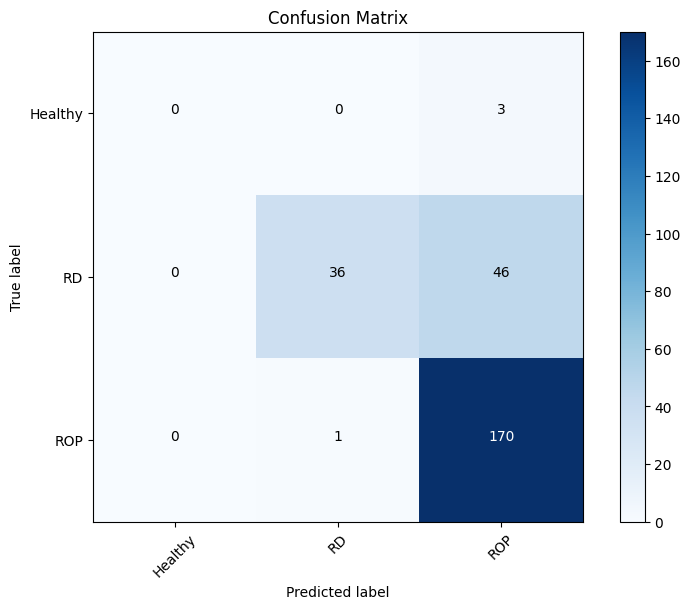

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to collect true labels from the generator
def collect_true_labels(generator, steps):
    y_true = []
    for _ in range(steps):
        _, batch_labels = next(generator)
        y_true.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot to class indices
    return np.array(y_true)

# Function to get class names from the dataset directory
def get_class_names(directory):
    return sorted(os.listdir(directory))

# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for prediction
test_steps = test_image_count // BATCH_SIZE

# Generate predictions with progress bar
predictions = model.predict(test_generator, steps=test_steps)  # Specify steps for prediction

# Collect true labels
y_true = collect_true_labels(test_generator, test_steps)

# Get predicted labels
y_pred = np.argmax(predictions, axis=1)

# Get class names
class_names = get_class_names(TEST_DIR)

# Identify unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate([y_true, y_pred]))

# Filter class names to include only the classes present in y_true and y_pred
filtered_class_names = [class_names[i] for i in unique_classes]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=filtered_class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(filtered_class_names))
plt.xticks(tick_marks, filtered_class_names, rotation=45)
plt.yticks(tick_marks, filtered_class_names)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [11]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'vgg16_rop_model_vs1.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/vgg16_rop_model_vs1.h5


# **setting up dataset (not needed)**

In [ ]:
# Install and download dataset
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CdeZJVrKXJQvsNCBSvks")
project = rf.workspace("airop").project("rop-vj9t0")
version = project.version(3)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ROP-3 in folder:: 100%|██████████| 4704/4704 [00:00<00:00, 8179.74it/s]


# **EfficientNetV2-L**

## **Import Libraries**

In [32]:
import os
import numpy as np
import tensorflow as tf
import cv2
from skimage import morphology, measure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetV2L
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Set Up Parameters**

In [33]:
# Dataset paths
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15


## **Data Preprocessing and Augmentation**

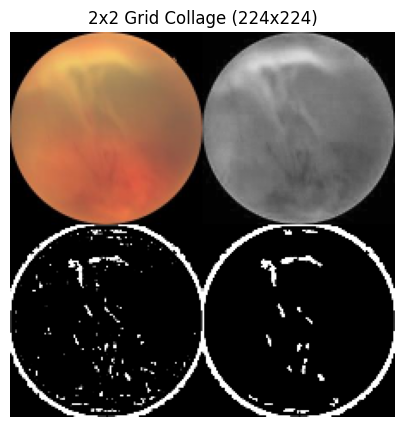

In [34]:
# Vessel Segmentation Function
def vessel_segmentation(image):
    # Step 1: Resize image
    resized_image = cv2.resize(image, (512, 512))

    # Step 2: Extract green channel and convert to uint8
    green_channel = resized_image[:, :, 1].astype(np.uint8)  # Ensure it's uint8

    # Step 3: Enhance using CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(green_channel)

    # Step 4: Apply adaptive thresholding and invert it
    adaptive_thresh_image = cv2.adaptiveThreshold(enhanced_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 25, 6)
    inverted_thresh_image = cv2.bitwise_not(adaptive_thresh_image)

    # Step 5: Apply median filtering to reduce noise
    median_filtered_image = cv2.medianBlur(inverted_thresh_image, 5)

    # Step 6: Apply morphological opening to remove small dots before dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened_image = cv2.morphologyEx(median_filtered_image, cv2.MORPH_OPEN, kernel)

    # Step 7: Apply morphological dilation with a smaller kernel size
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_image = cv2.dilate(opened_image, kernel)

    # Step 8: Remove small objects (increase min_size to remove smaller dots)
    labels = measure.label(dilated_image)
    cleaned = morphology.remove_small_objects(labels, min_size=100)
    final_image = (cleaned > 0).astype(np.uint8) * 255

    # Convert grayscale to 3-channel for visualization
    enhanced_image = cv2.merge([enhanced_image] * 3)
    inverted_thresh_image = cv2.merge([inverted_thresh_image] * 3)
    final_image = cv2.merge([final_image] * 3)

    return resized_image, enhanced_image, inverted_thresh_image, final_image

# Create 2x2 Grid Collage
def create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image):
    # Resize all images to half the size of the final collage (112x112)
    size = (112, 112)  # Each image will be 112x112
    resized_image = cv2.resize(resized_image, size)
    enhanced_image = cv2.resize(enhanced_image, size)
    inverted_thresh_image = cv2.resize(inverted_thresh_image, size)
    final_image = cv2.resize(final_image, size)

    # Create 2x2 grid
    top_row = np.hstack((resized_image, enhanced_image))  # Top row: Original + CLAHE
    bottom_row = np.hstack((inverted_thresh_image, final_image))  # Bottom row: Inverted + Final
    collage = np.vstack((top_row, bottom_row))  # Combine rows into 2x2 grid

    return collage

# Resize Collage to Target Size
def resize_collage(collage, target_size):

    return cv2.resize(collage, target_size)

# Get first image file in the training directory
first_class = os.listdir(TRAIN_DIR)[0]  # Get first class folder
first_class_path = os.path.join(TRAIN_DIR, first_class)
first_image_file = os.listdir(first_class_path)[2]  # Get first image file
first_image_path = os.path.join(first_class_path, first_image_file)

# Load the image
image = cv2.imread(first_image_path)

# Process the image and create the 2x2 collage
resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)

# Resize the collage to 224x224
collage = resize_collage(collage, (224, 224))

# Display the collage
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
plt.title("2x2 Grid Collage (224x224)")
plt.axis('off')
plt.show()

In [35]:
# Data Generators with Vessel Segmentation

# Custom Data Generator
def custom_data_generator(datagen, directory, target_size, batch_size, class_mode, shuffle=True):
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle  # Pass the shuffle argument
    )

    while True:
        batch_images, batch_labels = next(generator)

        collages = []
        for image in batch_images:
            # Ensure the image is in the correct format (uint8, [0, 255])
            if image.dtype != np.uint8:
                image = image.astype(np.uint8)

            # Process the image to create the collage
            resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
            collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)
            resized_collage = resize_collage(collage, target_size)
            # Rescale pixel values to [0, 1]
            resized_collage = resized_collage / 255.0
            collages.append(resized_collage)

        collages = np.array(collages)
        yield collages, batch_labels

# Preprocessing and Augmentation (without rescale)
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator()  # No rescale
test_datagen = ImageDataGenerator()   # No rescale

# Use the custom data generator
train_generator = custom_data_generator(train_datagen, TRAIN_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
valid_generator = custom_data_generator(valid_datagen, VALID_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
test_generator = custom_data_generator(test_datagen, TEST_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical', shuffle=False)

## **Build Function**

In [36]:
# Build and Compile the Model
# Load EfficientNetV2L 
regnet_base = EfficientNetV2L(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    regnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)        │ (None, 7, 7, 1280)          │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,750,691 (449.18 MB)

 Trainable params: 117,238,115 (447.23 MB)

 Non-trainable params: 512,576 (1.96 MB)

## **Train Model**

In [37]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_efficientnetv2_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Function to count the number of images in a directory
def count_images(directory):
    count = 0
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            count += len(os.listdir(class_path))
    return count

# Calculate the total number of images in the training and validation datasets
train_image_count = count_images(TRAIN_DIR)
valid_image_count = count_images(VALID_DIR)

# Calculate steps_per_epoch and validation_steps
train_steps = train_image_count // BATCH_SIZE
valid_steps = valid_image_count // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,  # Specify steps_per_epoch
    validation_data=valid_generator,
    validation_steps=valid_steps,  # Specify validation_steps
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Found 3877 images belonging to 3 classes.
Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.7921 - auc: 0.9125 - loss: 0.5300 - precision: 0.8133 - recall: 0.7513Found 549 images belonging to 3 classes.

Epoch 1: val_loss improved from inf to 0.52103, saving model to best_efficientnetv2_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.7926 - auc: 0.9128 - loss: 0.5289 - precision: 0.8137 - recall: 0.7521 - val_accuracy: 0.7923 - val_auc: 0.9207 - val_loss: 0.5210 - val_precision: 0.7937 - val_recall: 0.7849
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.9172 - auc: 0.9833 - loss: 0.2321 - precision: 0.9206 - recall: 0.9145
Epoch 2: val_loss did not improve from 0.52103
121/121 ━━━━━━━━━━━━━━━━━━━━ 257s 933ms/step - accuracy: 0.9172 - auc: 0.9833 - loss: 0.2320 - precision: 0.9206 - recall: 0.9146 - val_accuracy: 0.7427 - val_auc: 0.8731 - val_loss: 1.3022 - val_precision: 0.7427 - val_recall: 0.7427
Epoch 3/15
121/121 ━━━━━━━━━━

## **Plot Training History**

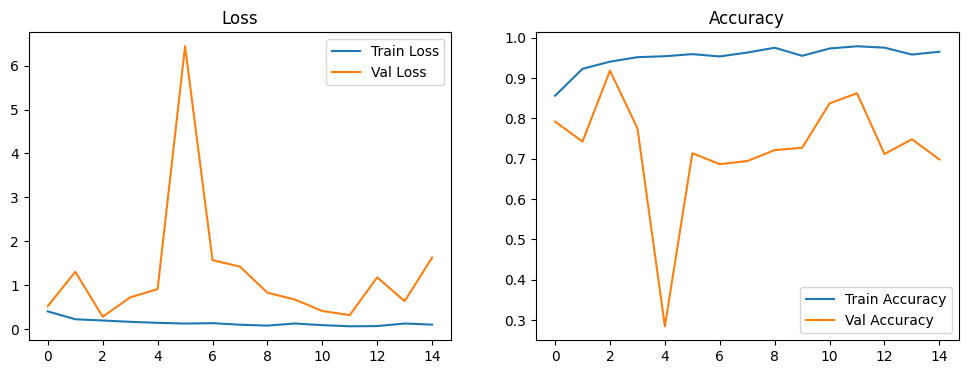

In [38]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


## **Evaluate the Model on Test Data**

In [40]:
# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for evaluation
test_steps = test_image_count // BATCH_SIZE

# Evaluate on Test Data
model.load_weights('best_efficientnetv2_model.keras')
evaluation_metrics = model.evaluate(test_generator, steps=test_steps)  # Specify steps for evaluation

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Found 275 images belonging to 3 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.8338 - auc: 0.9437 - loss: 0.4343 - precision: 0.8366 - recall: 0.8140
Test Loss: 0.3045
Test Accuracy: 0.9023
Test Precision: 0.9051
Test Recall: 0.8945
Test AUC: 0.9786


## **Confusion Matrix**

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 382ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.88      0.83      0.86        82
         ROP       0.91      0.95      0.93       171

    accuracy                           0.90       256
   macro avg       0.60      0.59      0.60       256
weighted avg       0.89      0.90      0.90       256


Confusion Matrix:
[[  0   1   2]
 [  0  68  14]
 [  0   8 163]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


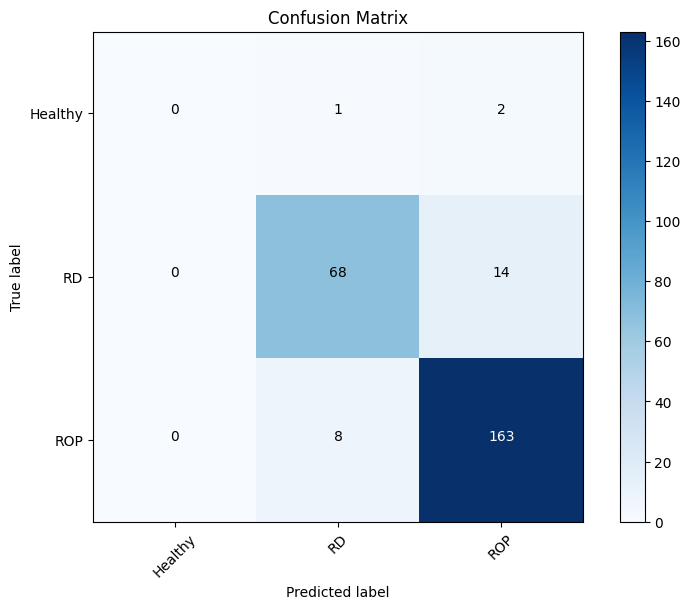

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to collect true labels from the generator
def collect_true_labels(generator, steps):
    y_true = []
    for _ in range(steps):
        _, batch_labels = next(generator)
        y_true.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot to class indices
    return np.array(y_true)

# Function to get class names from the dataset directory
def get_class_names(directory):
    return sorted(os.listdir(directory))

# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for prediction
test_steps = test_image_count // BATCH_SIZE

# Generate predictions with progress bar
predictions = model.predict(test_generator, steps=test_steps)  # Specify steps for prediction

# Collect true labels
y_true = collect_true_labels(test_generator, test_steps)

# Get predicted labels
y_pred = np.argmax(predictions, axis=1)

# Get class names
class_names = get_class_names(TEST_DIR)

# Identify unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate([y_true, y_pred]))

# Filter class names to include only the classes present in y_true and y_pred
filtered_class_names = [class_names[i] for i in unique_classes]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=filtered_class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(filtered_class_names))
plt.xticks(tick_marks, filtered_class_names, rotation=45)
plt.yticks(tick_marks, filtered_class_names)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [42]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"

os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'efficientnetv2_rop_model_vs1.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/saved_models/efficientnetv2_rop_model_vs1.h5


# **ResNet50V2**

## **Import Libraries**

In [44]:
# Import Libraries and Set Random Seeds
import os
import numpy as np
import tensorflow as tf
import cv2
from skimage import morphology, measure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50V2
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## **Dataset Paths and Parameters**

In [65]:
# Define dataset paths and parameters
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Preprocessing and Augmentation**

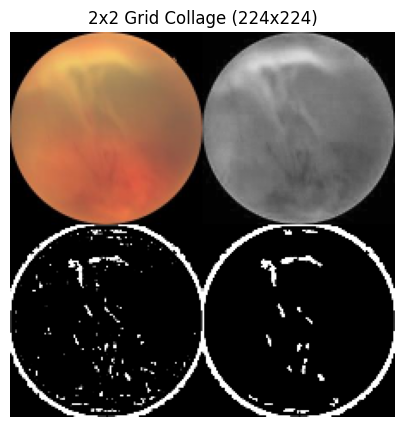

In [45]:
# Vessel Segmentation Function
def vessel_segmentation(image):
    # Step 1: Resize image
    resized_image = cv2.resize(image, (512, 512))

    # Step 2: Extract green channel and convert to uint8
    green_channel = resized_image[:, :, 1].astype(np.uint8)  # Ensure it's uint8

    # Step 3: Enhance using CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(green_channel)

    # Step 4: Apply adaptive thresholding and invert it
    adaptive_thresh_image = cv2.adaptiveThreshold(enhanced_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 25, 6)
    inverted_thresh_image = cv2.bitwise_not(adaptive_thresh_image)

    # Step 5: Apply median filtering to reduce noise
    median_filtered_image = cv2.medianBlur(inverted_thresh_image, 5)

    # Step 6: Apply morphological opening to remove small dots before dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened_image = cv2.morphologyEx(median_filtered_image, cv2.MORPH_OPEN, kernel)

    # Step 7: Apply morphological dilation with a smaller kernel size
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_image = cv2.dilate(opened_image, kernel)

    # Step 8: Remove small objects (increase min_size to remove smaller dots)
    labels = measure.label(dilated_image)
    cleaned = morphology.remove_small_objects(labels, min_size=100)
    final_image = (cleaned > 0).astype(np.uint8) * 255

    # Convert grayscale to 3-channel for visualization
    enhanced_image = cv2.merge([enhanced_image] * 3)
    inverted_thresh_image = cv2.merge([inverted_thresh_image] * 3)
    final_image = cv2.merge([final_image] * 3)

    return resized_image, enhanced_image, inverted_thresh_image, final_image

# Create 2x2 Grid Collage
def create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image):
    # Resize all images to half the size of the final collage (112x112)
    size = (112, 112)  # Each image will be 112x112
    resized_image = cv2.resize(resized_image, size)
    enhanced_image = cv2.resize(enhanced_image, size)
    inverted_thresh_image = cv2.resize(inverted_thresh_image, size)
    final_image = cv2.resize(final_image, size)

    # Create 2x2 grid
    top_row = np.hstack((resized_image, enhanced_image))  # Top row: Original + CLAHE
    bottom_row = np.hstack((inverted_thresh_image, final_image))  # Bottom row: Inverted + Final
    collage = np.vstack((top_row, bottom_row))  # Combine rows into 2x2 grid

    return collage

# Resize Collage to Target Size
def resize_collage(collage, target_size):

    return cv2.resize(collage, target_size)

# Get first image file in the training directory
first_class = os.listdir(TRAIN_DIR)[0]  # Get first class folder
first_class_path = os.path.join(TRAIN_DIR, first_class)
first_image_file = os.listdir(first_class_path)[2]  # Get first image file
first_image_path = os.path.join(first_class_path, first_image_file)

# Load the image
image = cv2.imread(first_image_path)

# Process the image and create the 2x2 collage
resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)

# Resize the collage to 224x224
collage = resize_collage(collage, (224, 224))

# Display the collage
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
plt.title("2x2 Grid Collage (224x224)")
plt.axis('off')
plt.show()

In [46]:
# Data Generators with Vessel Segmentation

# Custom Data Generator
def custom_data_generator(datagen, directory, target_size, batch_size, class_mode, shuffle=True):
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle  # Pass the shuffle argument
    )

    while True:
        batch_images, batch_labels = next(generator)

        collages = []
        for image in batch_images:
            # Ensure the image is in the correct format (uint8, [0, 255])
            if image.dtype != np.uint8:
                image = image.astype(np.uint8)

            # Process the image to create the collage
            resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
            collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)
            resized_collage = resize_collage(collage, target_size)
            # Rescale pixel values to [0, 1]
            resized_collage = resized_collage / 255.0
            collages.append(resized_collage)

        collages = np.array(collages)
        yield collages, batch_labels

# Preprocessing and Augmentation (without rescale)
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator()  # No rescale
test_datagen = ImageDataGenerator()   # No rescale

# Use the custom data generator
train_generator = custom_data_generator(train_datagen, TRAIN_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
valid_generator = custom_data_generator(valid_datagen, VALID_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
test_generator = custom_data_generator(test_datagen, TEST_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical', shuffle=False)

## **Function for Building Model**

In [47]:
# Build and Compile the Model
# Load ResNet50V2
resnext_base = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    resnext_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes
])
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,570,947 (89.92 MB)

 Trainable params: 23,525,507 (89.74 MB)

 Non-trainable params: 45,440 (177.50 KB)

## **Train the Model**

In [48]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_resnet50v2_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Function to count the number of images in a directory
def count_images(directory):
    count = 0
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            count += len(os.listdir(class_path))
    return count

# Calculate the total number of images in the training and validation datasets
train_image_count = count_images(TRAIN_DIR)
valid_image_count = count_images(VALID_DIR)

# Calculate steps_per_epoch and validation_steps
train_steps = train_image_count // BATCH_SIZE
valid_steps = valid_image_count // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,  # Specify steps_per_epoch
    validation_data=valid_generator,
    validation_steps=valid_steps,  # Specify validation_steps
    epochs=EPOCHS,
    callbacks=[checkpoint]
)


Found 3877 images belonging to 3 classes.
Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.8117 - auc: 0.9278 - loss: 0.5110 - precision: 0.8257 - recall: 0.8014Found 549 images belonging to 3 classes.

Epoch 1: val_loss improved from inf to 23.42516, saving model to best_resnet50v2_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 156s 865ms/step - accuracy: 0.8121 - auc: 0.9280 - loss: 0.5101 - precision: 0.8260 - recall: 0.8018 - val_accuracy: 0.2886 - val_auc: 0.4665 - val_loss: 23.4252 - val_precision: 0.2886 - val_recall: 0.2886
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.8988 - auc: 0.9755 - loss: 0.2860 - precision: 0.9016 - recall: 0.8971
Epoch 2: val_loss improved from 23.42516 to 1.24055, saving model to best_resnet50v2_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 121s 823ms/step - accuracy: 0.8988 - auc: 0.9755 - loss: 0.2859 - precision: 0.9016 - recall: 0.8971 - val_accuracy: 0.9052 - val_auc: 0.9533 - val_loss: 1.2405 - val_precision: 0.9052

## **Plot Training History**

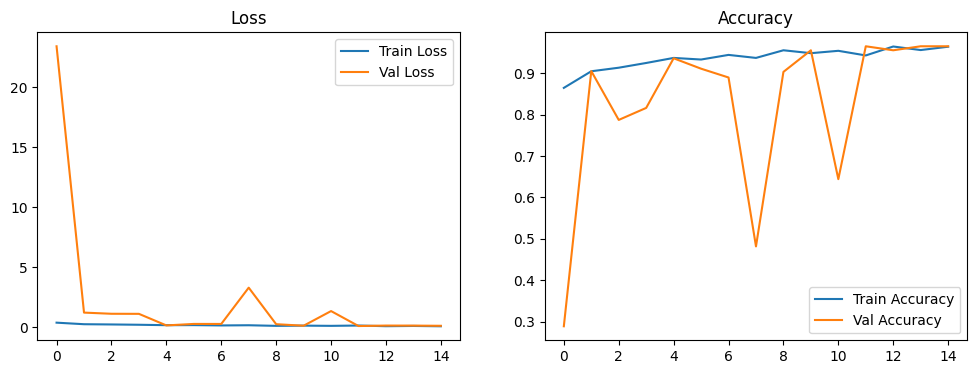

In [49]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate the Model on Test Data**

In [50]:
# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for evaluation
test_steps = test_image_count // BATCH_SIZE

# Evaluate on Test Data
model.load_weights('best_resnet50v2_model.keras')
evaluation_metrics = model.evaluate(test_generator, steps=test_steps)  # Specify steps for evaluation

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Found 275 images belonging to 3 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step - accuracy: 0.9132 - auc: 0.9881 - loss: 0.3038 - precision: 0.9132 - recall: 0.9132
Test Loss: 0.1757
Test Accuracy: 0.9453
Test Precision: 0.9453
Test Recall: 0.9453
Test AUC: 0.9952


## **Confusion Matrix**

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 385ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.94      0.93      0.93        82
         ROP       0.95      0.97      0.96       171

    accuracy                           0.95       256
   macro avg       0.63      0.63      0.63       256
weighted avg       0.93      0.95      0.94       256


Confusion Matrix:
[[  0   0   3]
 [  0  76   6]
 [  0   5 166]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


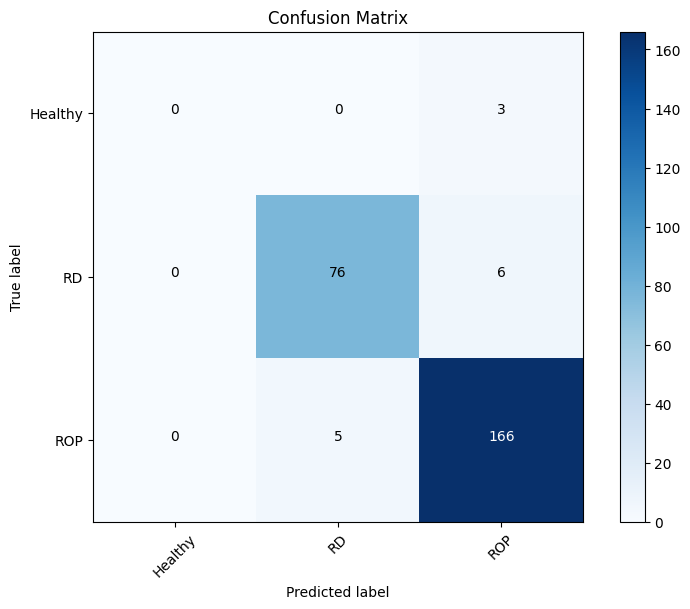

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to collect true labels from the generator
def collect_true_labels(generator, steps):
    y_true = []
    for _ in range(steps):
        _, batch_labels = next(generator)
        y_true.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot to class indices
    return np.array(y_true)

# Function to get class names from the dataset directory
def get_class_names(directory):
    return sorted(os.listdir(directory))

# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for prediction
test_steps = test_image_count // BATCH_SIZE

# Generate predictions with progress bar
predictions = model.predict(test_generator, steps=test_steps)  # Specify steps for prediction

# Collect true labels
y_true = collect_true_labels(test_generator, test_steps)

# Get predicted labels
y_pred = np.argmax(predictions, axis=1)

# Get class names
class_names = get_class_names(TEST_DIR)

# Identify unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate([y_true, y_pred]))

# Filter class names to include only the classes present in y_true and y_pred
filtered_class_names = [class_names[i] for i in unique_classes]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=filtered_class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(filtered_class_names))
plt.xticks(tick_marks, filtered_class_names, rotation=45)
plt.yticks(tick_marks, filtered_class_names)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [53]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'resnet50v2_rop_model_vs1.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/saved_models/resnet50v2_rop_model_vs1.h5


# **ConvNeXt**

## **Import Libraries and Set Random Seeds**

In [77]:

# Import Libraries and Set Random Seeds
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtBase  # ConvNeXt model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## **Dataset Paths and Parameters**

In [79]:
# Define dataset paths and parameters
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15


## **Data Preprocessing and Augmentation**

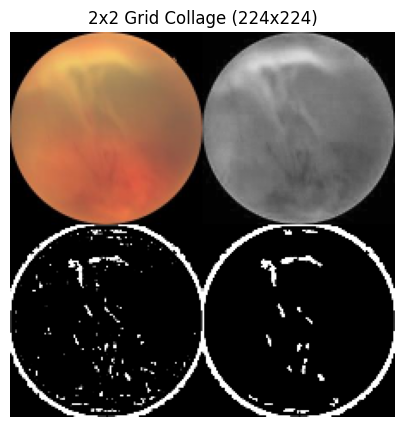

In [80]:
# Vessel Segmentation Function
def vessel_segmentation(image):
    # Step 1: Resize image
    resized_image = cv2.resize(image, (512, 512))

    # Step 2: Extract green channel and convert to uint8
    green_channel = resized_image[:, :, 1].astype(np.uint8)  # Ensure it's uint8

    # Step 3: Enhance using CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(green_channel)

    # Step 4: Apply adaptive thresholding and invert it
    adaptive_thresh_image = cv2.adaptiveThreshold(enhanced_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 25, 6)
    inverted_thresh_image = cv2.bitwise_not(adaptive_thresh_image)

    # Step 5: Apply median filtering to reduce noise
    median_filtered_image = cv2.medianBlur(inverted_thresh_image, 5)

    # Step 6: Apply morphological opening to remove small dots before dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened_image = cv2.morphologyEx(median_filtered_image, cv2.MORPH_OPEN, kernel)

    # Step 7: Apply morphological dilation with a smaller kernel size
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_image = cv2.dilate(opened_image, kernel)

    # Step 8: Remove small objects (increase min_size to remove smaller dots)
    labels = measure.label(dilated_image)
    cleaned = morphology.remove_small_objects(labels, min_size=100)
    final_image = (cleaned > 0).astype(np.uint8) * 255

    # Convert grayscale to 3-channel for visualization
    enhanced_image = cv2.merge([enhanced_image] * 3)
    inverted_thresh_image = cv2.merge([inverted_thresh_image] * 3)
    final_image = cv2.merge([final_image] * 3)

    return resized_image, enhanced_image, inverted_thresh_image, final_image

# Create 2x2 Grid Collage
def create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image):
    # Resize all images to half the size of the final collage (112x112)
    size = (112, 112)  # Each image will be 112x112
    resized_image = cv2.resize(resized_image, size)
    enhanced_image = cv2.resize(enhanced_image, size)
    inverted_thresh_image = cv2.resize(inverted_thresh_image, size)
    final_image = cv2.resize(final_image, size)

    # Create 2x2 grid
    top_row = np.hstack((resized_image, enhanced_image))  # Top row: Original + CLAHE
    bottom_row = np.hstack((inverted_thresh_image, final_image))  # Bottom row: Inverted + Final
    collage = np.vstack((top_row, bottom_row))  # Combine rows into 2x2 grid

    return collage

# Resize Collage to Target Size
def resize_collage(collage, target_size):

    return cv2.resize(collage, target_size)

# Get first image file in the training directory
first_class = os.listdir(TRAIN_DIR)[0]  # Get first class folder
first_class_path = os.path.join(TRAIN_DIR, first_class)
first_image_file = os.listdir(first_class_path)[2]  # Get first image file
first_image_path = os.path.join(first_class_path, first_image_file)

# Load the image
image = cv2.imread(first_image_path)

# Process the image and create the 2x2 collage
resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)

# Resize the collage to 224x224
collage = resize_collage(collage, (224, 224))

# Display the collage
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
plt.title("2x2 Grid Collage (224x224)")
plt.axis('off')
plt.show()

In [82]:
# Data Generators with Vessel Segmentation

# Custom Data Generator
def custom_data_generator(datagen, directory, target_size, batch_size, class_mode, shuffle=True):
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle  # Pass the shuffle argument
    )

    while True:
        batch_images, batch_labels = next(generator)

        collages = []
        for image in batch_images:
            # Ensure the image is in the correct format (uint8, [0, 255])
            if image.dtype != np.uint8:
                image = image.astype(np.uint8)

            # Process the image to create the collage
            resized_image, enhanced_image, inverted_thresh_image, final_image = vessel_segmentation(image)
            collage = create_2x2_collage(resized_image, enhanced_image, inverted_thresh_image, final_image)
            resized_collage = resize_collage(collage, target_size)
            # Rescale pixel values to [0, 1]
            resized_collage = resized_collage / 255.0
            collages.append(resized_collage)

        collages = np.array(collages)
        yield collages, batch_labels

# Preprocessing and Augmentation (without rescale)
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator()  # No rescale
test_datagen = ImageDataGenerator()   # No rescale

# Use the custom data generator
train_generator = custom_data_generator(train_datagen, TRAIN_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
valid_generator = custom_data_generator(valid_datagen, VALID_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical')
test_generator = custom_data_generator(test_datagen, TEST_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical', shuffle=False)

## **Function for Building Models**

In [83]:
# Build and Compile the Model
# Load ConvNeXt model
convnext_base = ConvNeXtBase(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    convnext_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()


350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,569,539 (334.05 MB)

 Trainable params: 87,569,539 (334.05 MB)

 Non-trainable params: 0 (0.00 B)

## **Train ConvNeXt**

In [84]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_convnext_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Function to count the number of images in a directory
def count_images(directory):
    count = 0
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            count += len(os.listdir(class_path))
    return count

# Calculate the total number of images in the training and validation datasets
train_image_count = count_images(TRAIN_DIR)
valid_image_count = count_images(VALID_DIR)

# Calculate steps_per_epoch and validation_steps
train_steps = train_image_count // BATCH_SIZE
valid_steps = valid_image_count // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,  # Specify steps_per_epoch
    validation_data=valid_generator,
    validation_steps=valid_steps,  # Specify validation_steps
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Found 3877 images belonging to 3 classes.
Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.6391 - auc: 0.8094 - loss: 1.0950 - precision: 0.6447 - recall: 0.6281Found 549 images belonging to 3 classes.

Epoch 1: val_loss improved from inf to 0.65593, saving model to best_convnext_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 193s 957ms/step - accuracy: 0.6393 - auc: 0.8096 - loss: 1.0927 - precision: 0.6450 - recall: 0.6283 - val_accuracy: 0.6967 - val_auc: 0.8438 - val_loss: 0.6559 - val_precision: 0.6967 - val_recall: 0.6967
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.7021 - auc: 0.8536 - loss: 0.6768 - precision: 0.7040 - recall: 0.7003
Epoch 2: val_loss improved from 0.65593 to 0.64707, saving model to best_convnext_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 140s 911ms/step - accuracy: 0.7021 - auc: 0.8536 - loss: 0.6769 - precision: 0.7040 - recall: 0.7002 - val_accuracy: 0.7137 - val_auc: 0.8520 - val_loss: 0.6471 - val_precision: 0.7137 - val_

## **Plot Training History**

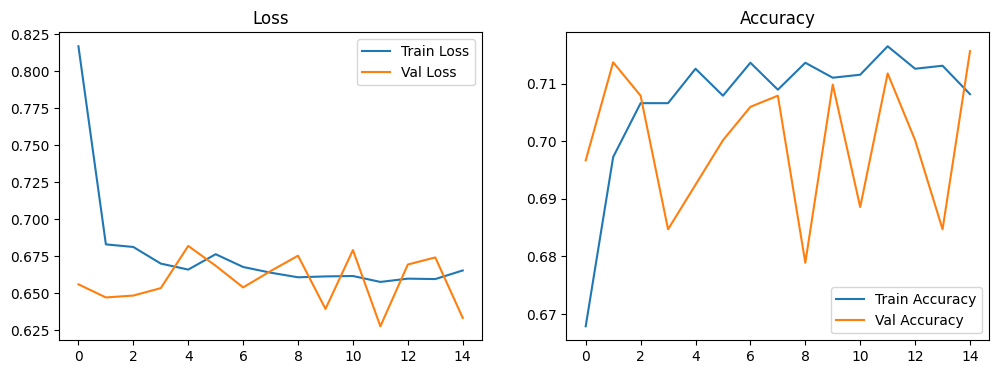

In [85]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Generate Reports And Visualizations**

In [86]:
# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for evaluation
test_steps = test_image_count // BATCH_SIZE

# Evaluate on Test Data
model.load_weights('best_convnext_model.keras')
evaluation_metrics = model.evaluate(test_generator, steps=test_steps)  # Specify steps for evaluation

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Found 275 images belonging to 3 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - accuracy: 0.3814 - auc: 0.6759 - loss: 0.9977 - precision: 0.3814 - recall: 0.3814      
Test Loss: 0.6923
Test Accuracy: 0.6680
Test Precision: 0.6680
Test Recall: 0.6680
Test AUC: 0.8281


## **Confusion Matrix**

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.00      0.00      0.00        82
         ROP       0.67      1.00      0.80       171

    accuracy                           0.67       256
   macro avg       0.22      0.33      0.27       256
weighted avg       0.45      0.67      0.54       256


Confusion Matrix:
[[  0   0   3]
 [  0   0  82]
 [  0   0 171]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


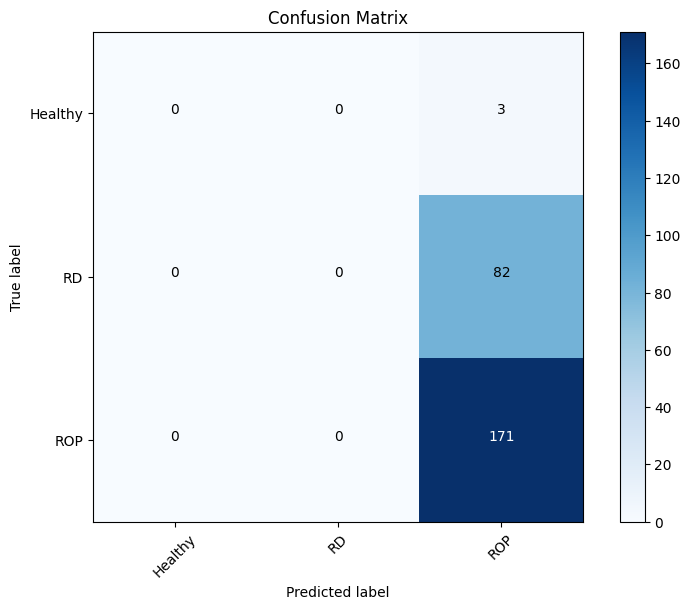

In [87]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to collect true labels from the generator
def collect_true_labels(generator, steps):
    y_true = []
    for _ in range(steps):
        _, batch_labels = next(generator)
        y_true.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot to class indices
    return np.array(y_true)

# Function to get class names from the dataset directory
def get_class_names(directory):
    return sorted(os.listdir(directory))

# Calculate the total number of images in the test dataset
test_image_count = count_images(TEST_DIR)

# Calculate the number of steps for prediction
test_steps = test_image_count // BATCH_SIZE

# Generate predictions with progress bar
predictions = model.predict(test_generator, steps=test_steps)  # Specify steps for prediction

# Collect true labels
y_true = collect_true_labels(test_generator, test_steps)

# Get predicted labels
y_pred = np.argmax(predictions, axis=1)

# Get class names
class_names = get_class_names(TEST_DIR)

# Identify unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate([y_true, y_pred]))

# Filter class names to include only the classes present in y_true and y_pred
filtered_class_names = [class_names[i] for i in unique_classes]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=filtered_class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(filtered_class_names))
plt.xticks(tick_marks, filtered_class_names, rotation=45)
plt.yticks(tick_marks, filtered_class_names)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [88]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'convnext_rop_model_vs1.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/saved_models/convnext_rop_model_vs1.h5
